In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DATA_DIR = "/beegfs/ua349/lstm/Penn_Action"

In [4]:
frames_dir = DATA_DIR + '/frames'
labels_dir = DATA_DIR + '/labels'

In [85]:
import os, sys
from scipy.io import loadmat

refs = []
SEQ_LEN = 6

# [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]
coco_incl = [0, None, 1, 3, 5, 2, 4, 6, 7, 9, 11, 8, 10, 12, None, None, None, None, None]
# TODO: 19th entry should be a maskish thing...?

frame_folders = os.listdir(frames_dir)
for __fii, fldr in enumerate(sorted(frame_folders, key=lambda val: int(val))):
    
    sys.stdout.write('%d/%d ~ %d\r' % (__fii, len(frame_folders), len(refs)))
    sys.stdout.flush()
    
    flpath = '%s/%s' % (frames_dir, fldr)
    imgs = [fl for fl in os.listdir(flpath)]
    imgs = sorted(imgs, key=lambda val: int(val.split('.')[0]))
    
    lblpath = '%s/%s' % (labels_dir, fldr)
    mat = loadmat(lblpath)
    xs, ys, bbox = mat['x'], mat['y'], mat['bbox']
    vis, dim = mat['visibility'], mat['dimensions']

    for bii in range(0, len(imgs), SEQ_LEN):
        ref = {
            'frames': [],
#             'labels': [],
            'boxes': [],
#             'local_coords': [],
            'coords': [],
            'coco_coords': [],
            'visibility': [],
        }
        
        
        if bii + SEQ_LEN >= len(imgs):
            rng = range(len(imgs) - SEQ_LEN, len(imgs))
        else:
            rng = range(bii, bii+SEQ_LEN)
        assert rng is not None
        
        for ii in rng:
            
            assert ii < len(xs)
            ref['frames'].append('%s/%s' % (flpath, imgs[ii]))

            try:
                # case where last bbox can be missing sometimes
                assert ii < len(bbox)
                box = bbox[ii]
            except:
                print('WARN: Missing bbox %s' % lblpath)
                print()
                box = bbox[ii-1] # just sub in last frame
                
            ref['boxes'].append(box)
            coords = [(x, y) for (x, y) in zip(xs[ii], ys[ii])]
            ref['coords'].append(coords)
            coco_coords = [(-1, -1) if ind is None else coords[ind] for ind in coco_incl]
            ref['coco_coords'].append(coco_coords)
            ref['visibility'].append(vis[ii])
        assert len(ref['frames']) == SEQ_LEN

        refs.append(ref)
print()
        
print(refs[0])
print('Collected sequences: %d (interval %d)' % (len(refs), SEQ_LEN))
    

WARN: Missing bbox /beegfs/ua349/lstm/Penn_Action/labels/1154

WARN: Missing bbox /beegfs/ua349/lstm/Penn_Action/labels/1865

2325/2326 ~ 28297
{'frames': ['/beegfs/ua349/lstm/Penn_Action/frames/0001/000001.jpg', '/beegfs/ua349/lstm/Penn_Action/frames/0001/000002.jpg', '/beegfs/ua349/lstm/Penn_Action/frames/0001/000003.jpg', '/beegfs/ua349/lstm/Penn_Action/frames/0001/000004.jpg', '/beegfs/ua349/lstm/Penn_Action/frames/0001/000005.jpg', '/beegfs/ua349/lstm/Penn_Action/frames/0001/000006.jpg'], 'boxes': [array([ 86.25,  45.75, 168.75, 350.25]), array([ 86.25,  41.25, 168.  , 349.5 ]), array([ 86.25,  41.25, 168.  , 348.75]), array([ 86.25,  45.  , 168.  , 348.75]), array([ 86.25,  41.25, 166.5 , 348.  ]), array([ 86.25,  45.  , 167.25, 348.  ])], 'coords': [[(136.5, 71.25), (135.0, 102.75), (102.75, 99.0), (160.5, 148.5), (141.0, 148.5), (162.0, 117.75), (154.5, 122.25), (114.75, 175.5), (107.25, 180.0), (142.5, 255.0), (102.0, 255.75), (141.75, 324.75), (93.0, 321.0)], [(131.25, 66.75)

In [40]:
# for fldr in sorted(os.listdir(labels_dir), key=lambda val: int(val.split('.')[0])):
#     flpath = '%s/%s' % (labels_dir, fldr)
#     mat = loadmat(flpath)
#     xs, ys, bbox = mat['x'], mat['y'], mat['bbox']
#     vis, dim = mat['visibility'], mat['dimensions']
#     print(mat.keys())
#     print(vis.shape, dim)
#     print(xs.shape, ys.shape, bbox.shape)
#     assert False
#     lbls = [fl for fl in os.listdir(flpath)]
#     imgs = sorted(imgs, key=lambda val: int(val.split('.')[0]))
# #     numBats = int(len(imgs) / SEQ_LEN)
#     for bii in range(0, len(imgs), SEQ_LEN):
# #         if bii + SEQ_LEN > len(imgs)
#         ref = {
#             'frames': [],
#             'labels': []
#         }
#         if bii + SEQ_LEN > len(imgs):
#             for ll in range(len(imgs) - SEQ_LEN, len(imgs)):
#                 ref['frames'].append('%s/%s' % (flpath, imgs[ll]))
#         else:
#             for ii in range(SEQ_LEN):
#                 ref['frames'].append('%s/%s' % (flpath, imgs[bii + ii]))
#         refs.append(ref)

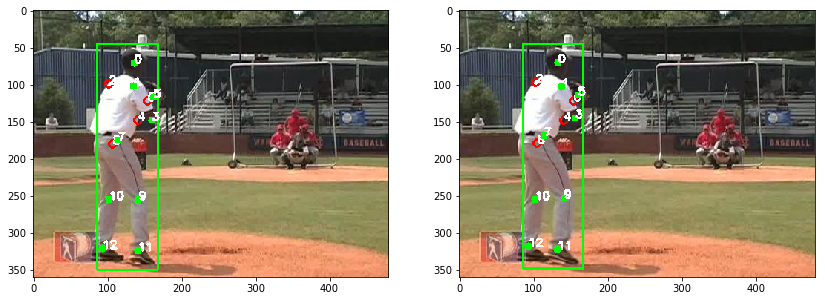

In [83]:
import cv2
import matplotlib.pyplot as plt

def load_images(ref):
    imgs = []
    for path in ref['frames']:
#         print(path)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        imgs.append(img)
#         print(img.shape, img.dtype)
    assert len(imgs) > 0
#     print(len)
    return imgs
        
imgs = load_images(refs[0])


font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 0.5
fontColor              = (255,255,255)
lineType               = 2



def annotate(imgs, metas, ind):
    x0, y0, xf, yf = metas['boxes'][ind]
    canvas = imgs[ind].copy()
    cv2.rectangle(canvas, (int(x0), int(y0)), (int(xf), int(yf)), (0,255,0), 2)
    for ii in range(13):
        x, y = metas['coords'][ind][ii]
        visible = metas['visibility'][ind][ii]
        if not visible:
            cv2.circle(canvas, (int(x), int(y)), 5, (255, 0, 0), 2)
            cv2.putText(canvas,'%d' % ii, 
                (int(x), int(y)), 
                font, 
                fontScale,
                fontColor,
                lineType)
    for ii in range(13):
        x, y = metas['coords'][ind][ii]
        visible = metas['visibility'][ind][ii]
        if visible:
            cv2.circle(canvas, (int(x), int(y)), 5, (0, 255, 0), -1)
            cv2.putText(canvas,'%d' % ii, 
                (int(x), int(y)), 
                font, 
                fontScale,
                fontColor,
                lineType)
        
    return canvas

plt.figure(figsize=(14, 10))
plt.subplot(1, 2, 1)
plt.imshow(annotate(imgs, refs[0], 0))
plt.subplot(1, 2, 2)
plt.imshow(annotate(imgs, refs[0], -1))
plt.show()
        